# Amazon Book Review Modeling

##Import Library

In [2]:
!pip install ftfy
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.5 MB/s eta 0:00:00


In [3]:
!pip uninstall scipy -y
!pip install scipy==1.10.1

Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is

In [4]:
!pip install gensim==4.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 95.1 MB/s eta 0:00:00


In [173]:
## Import Libraries
import pandas as pd
import numpy as np

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.decomposition import TruncatedSVD

from ftfy import fix_text
from unidecode import unidecode
import unicodedata

from wordcloud import WordCloud

from sklearn.preprocessing import MaxAbsScaler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    classification_report,
    auc
)

import warnings
warnings.filterwarnings('ignore')


##Load filtered CSV file

In [174]:
book_filtered = pd.read_csv('/content/drive/MyDrive/Capstone_Project_IOD/book_filtered_2020_eoD.csv')

In [189]:
ratings_filtered = pd.read_csv('/content/drive/MyDrive/Capstone_Project_IOD/ratings_filtered_2020_eoD.csv')

In [190]:
ratings_filtered.shape

(26609, 9)

In [191]:


# We need to concatenate the review string in order to generate the word cloud
reviews = ratings_filtered['review'].str.cat(sep=' ')

reviews[:500]






"The 1933 Scribner's edition of this classic trilogy is worthwhile because of the preface by Ada Galsworthy, the author's wife. Combined with the dedication (from John to Ada), it paints an inspiring picture of a marriage between two creative minds who respected each other's talents. The trilogy itself is an inspiring artifact of a life spent working hard. Galsworthy finished the first book, Man of Property in 1906, at the age of 39. He put the project aside for something like 12 years and then f"

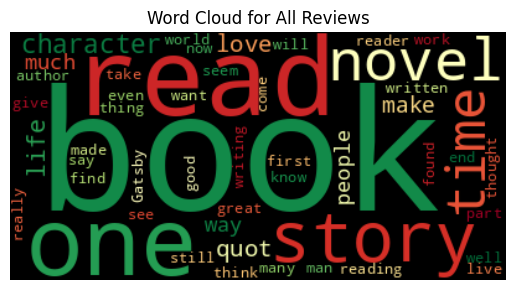

CPU times: user 6.91 s, sys: 280 ms, total: 7.19 s
Wall time: 7.05 s


In [192]:
%%time
from wordcloud import WordCloud

cloud = WordCloud(max_words=50, background_color='black', colormap='RdYlGn',
                  normalize_plurals=True)

cloud.generate(reviews)

plt.imshow(cloud, interpolation='bilinear')  # Render the word cloud image
plt.axis('off')  # Hide axes
plt.title('Word Cloud for All Reviews')
plt.show()

In [193]:
# Delete the reviews variable to free the memory
del reviews

### Text Preprocessing

In [194]:
# Load spaCy's English model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

batch_size = 5000

In [195]:
custom_stop_words = ['book','read','story','time','quot','think','novel','character']

In [196]:

from nltk.tokenize import word_tokenize

def preprocess_text(df, text_col="Review", custom_stop_words=custom_stop_words):
    """
    Function to clean the text and assign clean text into a new column using the nlp pipeline.
    """

    # Add custom stop words to spaCy's stop words list
    for word in custom_stop_words:
        nlp.vocab[word].is_stop = True



     # vectorized regex cleaning
    df[text_col] = (
        df[text_col]
        .str.replace(r'\d+', '', regex=True)                  # remove digits
        .str.replace(r'(\s{2,}|\n{2,})', ' ', regex=True)      # collapse spaces/newlines
        .str.replace(r'"+', '', regex=True)
        .str.replace(r'quot+', '', regex=True)                     # remove quotes
        .str.replace(r'[^A-Za-z\s]', '', regex=True)          # keep only letters & spaces
    )

    # 3) Unicode normalization + ASCII fallback, applied elementwise
        # Change every accented character into a base character plus one or more combining accents.
        # E.g. “é” → “e” + “́” (COMBINING ACUTE ACCENT).
        # Remove Emoticon
    def _normalize(s: str) -> str:
        s = fix_text(s)                                      # your custom fix
        # strip combining diacritics
        s = ''.join(ch for ch in unicodedata.normalize('NFKD', s)
                    if not unicodedata.combining(ch))
        return unidecode(s)                                  # transliterate remaining

    df[text_col] = df[text_col].astype(str).apply(_normalize)


    # Step 1: Build an NLP pipe
    nlp_pipe = nlp.pipe(df[text_col], batch_size=batch_size, disable=["ner", "parser"])

    # Step 2: Remove punctuation, stopwords, and then lemmatization
    tokens = []
    for doc in nlp_pipe:
        # Filter out punctuation and stop words
        filtered_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        tokens.append(filtered_tokens)

    # Filtering out custom stop words (lemmas)
    filtered_tokens = [[token for token in doc if token not in custom_stop_words]
                       for doc in tokens]


    # Join tokens to create a cleaned text column
    df['processed_reviews'] = [' '.join(token) for token in filtered_tokens]

    return df

# # Sample text
# # sample_text_series = pd.Series({'Review': ["She nicely made a created a plan and will execute it."]})
# sample_text_series = pd.DataFrame({'Review': ["what nice hotel rooms with a pleasant view.",
#                                               "not a good restaurant to dine at, waiter is terrible."]})

# # Demonstration usage - test the function on the sample text
# words_lemmatized = preprocess_text(sample_text_series)
# pd.DataFrame(words_lemmatized)


In [197]:
%%time

preprocess_text(ratings_filtered, text_col='review')

CPU times: user 3min 12s, sys: 18.6 s, total: 3min 31s
Wall time: 3min 30s


,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews
0,5867,B000I83ZJC,The Forsythe Saga,NaN,A1TNG2A1GAG14B,5.0,The Scribners edition of this classic trilogy is worthwhile because of the preface by Ada Galsworthy the authors wife Combined with the dedication from John to Ada it paints an inspiring picture of a marriage between two creative minds who respected each others talents The trilogy itself is an inspiring artifact of a life spent working hard Galsworthy finished the first book Man of Property in at the age of He put the project aside for something like years and then finished the last two novels when in his mids Most people only read the first book but the last two deepened my appreciation for the first and for Galsworthys talent,2000-04-29,1,Scribners edition classic trilogy worthwhile preface Ada Galsworthy author wife combine dedication John Ada paint inspiring picture marriage creative mind respect talent trilogy inspiring artifact life spend work hard Galsworthy finish Man Property age project aside like year finish mid people deepen appreciation Galsworthys talent
1,5868,B000I83ZJC,The Forsythe Saga,NaN,A1U0WO33TVDE9K,5.0,The writing evident in this epic is masterful and engaging it is even and substantive and elegant The rich irony about the lengths that men strive to acquire property in all its forms and then find their acquisitions useless meaningless and certainly not worth the price Galworthy was focused upon property in so many different varieties the sense of possession that men had of their wives in his time amid archaic laws about divorce the building of a home that ends in unexpected expense in chancery the elusive value of works of art the subtleties of property from family crests clubs colleges and occupational status and cuts of mutton to the blatant futility of fighting over land in South Africa during the Boer War its all shallow and empty materialism in the end The property is never worth the cost of the trouble to acquire it Young people slave to gather possessions only to regret in old age that they have traded so much of life away to gain them and must undergo the painful rigors of its redistribution through wills after death Galsworthy seemed to me like a sort of British Tolstoy writing in England for property reform Because when property is involved men tend to objectify about it and in the course of things they tend to lose their sense of humanity This troublesome pattern of life seems to repeat itself often like a lesson men never learn as the objectifying IIt relationship of Martin Buber replaces the humane IThou Yes its a long novel but when the writing is this compelling in its style and substance you can luxuriate in the beauty and wisdom of the words Every character is finely and individually drawn like a character in a Velasquez portrait of a large family You may regret that this edition isnt longer when it ends but fortunately there is more of his work in which to indulge Galsworthys work earned him a Nobel Prize its easy to see the astonishing depth and range and virtuosity that the Nobel judges found in his writing Dont pass up the chance to bask in this epic saga of Galsworthy Its easily one of the top ten novels ever written in the English language its really that good,2001-12-13,1,writing evident epic masterful engage substantive elegant rich irony length man strive acquire property form find acquisition useless meaningless certainly worth price Galworthy focus property different variety sense possession man wife amid archaic law divorce building home end unexpected expense chancery elusive value work art subtlety property family crest club college occupational status cut mutton blatant futility fight land South Africa Boer War shallow materialism end property worth cost trouble acquire young people slave gather possession regret old age trade life away gain undergo painful rigor redistribution will death Galsworthy like sort Br

In [198]:
ratings_filtered.head()


,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews
0,5867,B000I83ZJC,The Forsythe Saga,NaN,A1TNG2A1GAG14B,5.0,The Scribners edition of this classic trilogy is worthwhile because of the preface by Ada Galsworthy the authors wife Combined with the dedication from John to Ada it paints an inspiring picture of a marriage between two creative minds who respected each others talents The trilogy itself is an inspiring artifact of a life spent working hard Galsworthy finished the first book Man of Property in at the age of He put the project aside for something like years and then finished the last two novels when in his mids Most people only read the first book but the last two deepened my appreciation for the first and for Galsworthys talent,2000-04-29,1,Scribners edition classic trilogy worthwhile preface Ada Galsworthy author wife combine dedication John Ada paint inspiring picture marriage creative mind respect talent trilogy inspiring artifact life spend work hard Galsworthy finish Man Property age project aside like year finish mid people deepen appreciation Galsworthys talent
1,5868,B000I83ZJC,The Forsythe Saga,NaN,A1U0WO33TVDE9K,5.0,The writing evident in this epic is masterful and engaging it is even and substantive and elegant The rich irony about the lengths that men strive to acquire property in all its forms and then find their acquisitions useless meaningless and certainly not worth the price Galworthy was focused upon property in so many different varieties the sense of possession that men had of their wives in his time amid archaic laws about divorce the building of a home that ends in unexpected expense in chancery the elusive value of works of art the subtleties of property from family crests clubs colleges and occupational status and cuts of mutton to the blatant futility of fighting over land in South Africa during the Boer War its all shallow and empty materialism in the end The property is never worth the cost of the trouble to acquire it Young people slave to gather possessions only to regret in old age that they have traded so much of life away to gain them and must undergo the painful rigors of its redistribution through wills after death Galsworthy seemed to me like a sort of British Tolstoy writing in England for property reform Because when property is involved men tend to objectify about it and in the course of things they tend to lose their sense of humanity This troublesome pattern of life seems to repeat itself often like a lesson men never learn as the objectifying IIt relationship of Martin Buber replaces the humane IThou Yes its a long novel but when the writing is this compelling in its style and substance you can luxuriate in the beauty and wisdom of the words Every character is finely and individually drawn like a character in a Velasquez portrait of a large family You may regret that this edition isnt longer when it ends but fortunately there is more of his work in which to indulge Galsworthys work earned him a Nobel Prize its easy to see the astonishing depth and range and virtuosity that the Nobel judges found in his writing Dont pass up the chance to bask in this epic saga of Galsworthy Its easily one of the top ten novels ever written in the English language its really that good,2001-12-13,1,writing evident epic masterful engage substantive elegant rich irony length man strive acquire property form find acquisition useless meaningless certainly worth price Galworthy focus property different variety sense possession man wife amid archaic law divorce building home end unexpected expense chancery elusive value work art subtlety property family crest club college occupational status cut mutton blatant futility fight land South Africa Boer War shallow materialism end property worth cost trouble acquire young people slave gather possession regret old age trade life away gain undergo painful rigor redistribution will death Galsworthy like sort Br

In [199]:
ratings_filtered.tail()

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews
26604,2952697,B000PLZI2E,Crusade in Europe,NaN,AFITDZEWKJKAM,4.0,General Eisenhower presents a very unique perspective on the ETO throughout Crusade in Europe since he was the one and only Supreme Allied Commander in the theatre In his role as Commander he was privy to a vast array of the decision making discussions that took place to create the Allied strategy against Nazi Germany In this book he brings to light a lot of the strategic thinking and planning that went into the Allied victory in WWII Therefore I would consider this book required reading for anyone interested in WWII historyHaving said that I think that the book does fall short of its objective for two main reasons First Ike is hesitant to criticize other leaders for bad decisions and tactical mistakes For instance Ike blames the lack of success in Operation Market Garden more on the weather than the ill conceived plan that Monty used to execute this daring mission Secondly Ike does not display much emotion when telling the tale For example when Ike talks about the Battle of the Bulge he infurs that the Allies expected the attack and felt almost no panic when it came If you look at books from others involved in the fighting you get a much different perspectiveOverall I enjoyed this book and wished I could give it stars It should be a star book because of the unique position that Ike fulfilled in the ETO Instead I give it stars but highly recommend it to anyone interested in WWII history,2003-03-05,1,General Eisenhower present unique perspective ETO Crusade Europe Supreme Allied Commander theatre role Commander privy vast array decision make discussion take place create allied strategy Nazi Germany bring light lot strategic thinking planning go allied victory WWII consider require reading interested WWII historyhaving say fall short objective main reason Ike hesitant criticize leader bad decision tactical mistake instance Ike blame lack success Operation Market Garden weather ill conceive plan Monty execute daring mission Secondly Ike display emotion tell tale example Ike talk Battle Bulge infur Allies expect attack feel panic come look involve fighting different perspectiveoverall enjoy wish star star unique position Ike fulfil ETO instead star highly recommend interested WWII history
26605,2952698,B000PLZI2E,Crusade in Europe,NaN,A3LXBNTQOMTXJ7,4.0,Very good book for someone seeking the view of the War in Europe from Supreme Commander of the Allied Forces essentially the CEO of the war in the west Not a ghostwritten account and at times its difficult to keep straight the onestar and twostar generals as Ike mentions the name what he did and whether he was British Canadian or American A professionial writer although this is still a very readable book would add a physical desription and when the name comes up again that writer would refer to him as the British generalI read Churchills Second World War before this and its interesting to see Churchills various rebuttals to criticisms by Ike of the Prime Minister There werent that many of themOne almost comical account was Churchills insistance that he visit the Normandy beacheson DDay Luckily King George stepped in and resolved the situation and kept the yearold Prime Minister in London on June Ike does a pretty good job of keeping the Zeuslike egos of Montgomery Patton and DeGaulle in check tooIn my opinion Eisenhower doesnt get as much credit as he deserves as just getting a force of the size of the Allied Expeditionary Force supplied with ammnuniton fuel food and the like was a monumental task,2004-12-13,1,good seek view War Europe Supreme Commander Allied Forces essentially ceo war west ghostwritten account difficult straight onestar twostar general Ike mention british canadian american professionial writer readable add physical desription come writer refer British generalI Churchills Second World War interesti

In [200]:
ratings_filtered[ratings_filtered['rating']<=2]

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews
13,5880,B000I83ZJC,The Forsythe Saga,NaN,A1YD7INTZZXD0U,2.0,I bought this book for my book club and I have had a very hard time reading it The characters are too lifelike in my opinion for me to have any sympathy towards them I have read other novels from the Victorian Period that I have liked but this one seems overly wordy and dull in my opinion I gave two stars instead of one for the mini novel Indian Summer of a Forsyte the best part of the series which saved this from a one star reveiw It was touching and beautiful to read If only the rest of the books followed such a formula,2006-11-06,0,buy club hard lifelike opinion sympathy victorian Period like overly wordy dull opinion give star instead mini Indian Summer Forsyte good series save star reveiw touch beautiful rest follow formula
18,5888,B000I83ZJC,The Forsythe Saga,NaN,A16YOB8YFHID3Y,2.0,Having first viewed the TV version of this story I find that the written version tends to be overlong and overdetailed I am not that interested in the brand of cigars that old Jolyon smokes I am only about chapters into the book and hope it gets livlier soon,2012-10-16,0,have view tv version find write version tend overlong overdetaile interested brand cigar old Jolyon smoke chapter hope get livli soon
39,27319,B000JJ9ISM,The Daughter of Time,NaN,A2WKD4UVQ109G3,2.0,the book is very boring for my taste but its essential for what you may have to study for the class,2013-01-28,0,boring taste essential study class
42,27323,B000JJ9ISM,The Daughter of Time,NaN,A1IZELD1R6ZJ67,1.0,Actually Tey would likely be pleased at me saying she is not a historian since according to her historians are silly among those many people with no common sense or psychological acuity and inability to reason properly In this book as in others by Tey she shows herself to be a misanthrope with a special emphasis on misogyny Shes a Tory who prefers people to know their place and believes that sparing the rod spoils the child Shes condescending and smug about her Inspector Alan Grants realization that Richard III cant have killed his nephews because first of all he doesnt look like a murderer In this book Grant is bedbound with a broken leg and to entertain him when he ungraciously rejects the books given him a friend brings him pictures of faces associated with some historical mystery One of these is a portrait alleged to depict Richard III and before he looks at the name Grant decides this is the face of some distinguished person likely someone on the bench rather than in the dock disturbingly Tey appears to believe that anyone in the dock is a criminal no presumption of innocence for herSo Grant is quite surprised to find that his thoughtful judicial person is actually Richard III presumed murderer of his nephews socalled the Princes in the Tower Puzzled Grant spends hours wondering how he could be so wrong and soon delving into histories of the period to find out why A reader might easily think that all this angst is more about Grant finding himself wrong in his apparently infallible ability to read faces so a minor character asks Grant but surely you dont believe in reading faces and Grant assures himus that no he doesnt but clearly he does disclaimers to the contrary This is really annoying for those who dont believe in phrenology and who might find GrantsTeys crush on a picture and post hoc attempt to heroize its subject embarrassingGrants actress friend Marta follows up the pictures with a woolly lamb an American lad called Brent Carradine who acts as Grants legs in undertaking research at places like the British Museum When the lamb finds out discouraging evidence eg that there were contemporary records of rumours that Richard had done away with the princes Grant easily finds explanations pointing to his chosen villain Henry VII insteadThis book has generally been praised as a unique detective novel which i

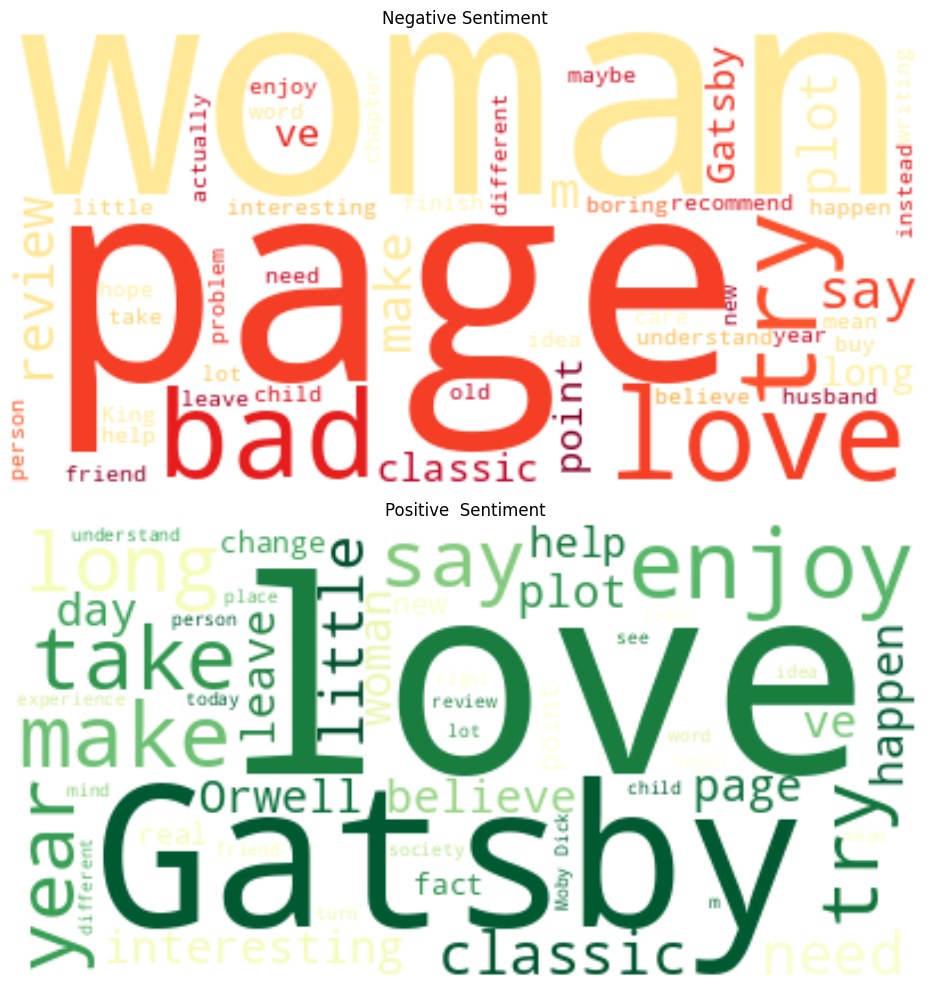

CPU times: user 6.58 s, sys: 364 ms, total: 6.94 s
Wall time: 6.66 s


In [201]:
%%time

from wordcloud import WordCloud, STOPWORDS

# Suppose this is your list of extra stop-words
stop_words = ['also', 'get', 'another', 'example','know','good'
              ,'people', 'life','find','want','well','go','great','write',
              'character','novel','man','way','work','come','send','author'
              ,'thing', 'world','end','tell','reader','feel','s','live',
              'look','give','start','war']

# Combine WordCloud’s built-in STOPWORDS with your own
custom_stops = STOPWORDS.union(stop_words)

# Create subplots for visualizing word clouds
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Sentiment categories
sentiments = { 0: "Negative Sentiment", 1: "Positive  Sentiment" }
colormap_list = ["YlOrRd", "YlGn"]

# Generate word clouds for each sentiment in a loop
for i, (sentiment, title) in enumerate(sentiments.items()):
    reviews = ratings_filtered.loc[ratings_filtered['sentiment'] == sentiment, 'processed_reviews'].str.cat(sep=' ')
    word_cloud = WordCloud(max_words=50, normalize_plurals=True,
                           stopwords=custom_stops,
                           colormap=colormap_list[i], background_color='white').generate(reviews)

    # Save word cloud to a file
    word_cloud.to_file(f"word_cloud_{sentiment}.png")

    ax[i].imshow(word_cloud, interpolation='bilinear')  # Render the word cloud image
    ax[i].axis('off')  # Hide axes
    ax[i].set_title(title)  # Set title

plt.tight_layout()  # Adjust spacing
plt.show()
#plt.savefig("wordclouds.png")


#Negative sentiment: whale, page, Moby Dick, Hemingway, classic
#Positive Sentitment: love, Moby Dick, Meville, enjoy, Maugham

### Split Data into train and test

In [202]:
X = ratings_filtered['processed_reviews']
y = ratings_filtered['sentiment']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Feature Engineering using TF-IDF

In [204]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   max_df=0.9, stop_words='english',
                                 use_idf=True, smooth_idf=True,
                                 sublinear_tf=True,
                                   ngram_range = (1, 3),
                                   max_features = 1000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_df=0.9, max_features=1000, ngram_range=(1, 3),
                stop_words='english', sublinear_tf=True,
                token_pattern='\\w{1,}')
CPU times: user 11.4 s, sys: 158 ms, total: 11.6 s
Wall time: 11.5 s


In [205]:
X_train_tfidf_ngram.shape

(21287, 1000)

###use MaxAbsScaler()

In [206]:
# 3. Create and fit the MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(X_train_tfidf_ngram)  # Fit only on training data

# 4. Transform the training and test data using the scaler
X_train_scaled = scaler.transform(X_train_tfidf_ngram)
X_test_scaled = scaler.transform(X_test_tfidf_ngram)

 ### Dimensionality reduction using truncated SVD

In [207]:
# 1. Create a TruncatedSVD object
svd = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10, random_state=42)  # Adjust n_components as needed

# 2. Fit SVD to the training data
svd.fit(X_train_scaled)

# 3. Transform the training and test data
X_train_svd = svd.transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

### Topic Modeling for negative reviews

In [208]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# package to print
from pprint import pprint

#### Tokenize processed reviews

In [209]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [210]:


from nltk.tokenize import word_tokenize

#ratings_filtered["processed_review_tokens"] = ratings_filtered["processed_reviews"].apply(word_tokenize)

neg_tokens = ratings_filtered.loc[ratings_filtered.sentiment == 0, "processed_reviews"].apply(word_tokenize)


#### Prepare dictionary and corpus for topic modeling

In [211]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus
# Create the Dictionary and Corpus needed for Topic Modelling

#  Dictionary
id2word = corpora.Dictionary(neg_tokens)

#  Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in neg_tokens]


#### Fit LDA model

In [212]:
%%time
n = 7 # decided to start with 4 topics. There are advanced approaches like Kullback Leibler Divergence
                                                              # to obtain the optimal number of topics.

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Look at the topics and key words
pprint(lda_model.print_topics())





[(0,
  '0.031*"ship" + 0.022*"cover" + 0.017*"old" + 0.015*"edition" + '
  '0.014*"public" + 0.014*"publish" + 0.014*"version" + 0.014*"word" + '
  '0.012*"have" + 0.012*"Kindle"'),
 (1,
  '0.034*"gas" + 0.016*"use" + 0.015*"die" + 0.013*"War" + 0.013*"author" + '
  '0.012*"clothe" + 0.012*"find" + 0.012*"sink" + 0.011*"incident" + '
  '0.011*"true"'),
 (2,
  '0.027*"child" + 0.026*"certainly" + 0.026*"hour" + 0.018*"experience" + '
  '0.017*"class" + 0.014*"wonder" + 0.012*"offer" + 0.012*"Ms" + '
  '0.009*"clearly" + 0.008*"self"'),
 (3,
  '0.024*"write" + 0.021*"not" + 0.019*"page" + 0.015*"bad" + 0.014*"author" + '
  '0.014*"review" + 0.013*"year" + 0.012*"come" + 0.012*"m" + 0.011*"end"'),
 (4,
  '0.052*"John" + 0.023*"friendly" + 0.022*"poison" + 0.022*"World" + '
  '0.022*"Liberty" + 0.020*"poisonous" + 0.010*"attract" + 0.009*"BOOK" + '
  '0.008*"jade" + 0.008*"Pyle"'),
 (5,
  '0.040*"not" + 0.030*"like" + 0.025*"know" + 0.015*"good" + 0.015*"want" + '
  '0.014*"s" + 0.013*"lov

Calculate the topic distribution

In [213]:
def topics_per_review(model, corpus):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs, _, _ = model[corp]
        dominant_topic = max(topic_percs, key=lambda x: x[1])[0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_review(model=lda_model, corpus=corpus)

In [214]:
topic_percentages_df = pd.DataFrame([
    {topic: prob for topic, prob in doc} for doc in topic_percentages
]).fillna(0)

dominant_topics_df = pd.DataFrame(dominant_topics,
                                  columns=["index", "topic"]).set_index("index")

topics_df = pd.merge(dominant_topics_df, topic_percentages_df,
                     left_index=True, right_index=True, how="left")

# Ensure column order is correct
topic_df = topics_df.loc[:, ["topic"] + list(range(n))]

# Display the resulting DataFrame
display(topic_df)

,topic,0,1,2,3,4,5,6
index,,,,,,,,
0,5,0.068978,0.071933,0.000000,0.000000,0.036499,0.808707,0.000000
1,0,0.717073,0.144837,0.000000,0.000000,0.000000,0.112008,0.000000
2,3,0.023820,0.023820,0.357357,0.523541,0.023820,0.023820,0.023820
3,1,0.184674,0.354057,0.167459,0.051158,0.000000,0.193623,0.043205
4,3,0.000000,0.196517,0.000000,0.759731,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2896,5,0.038969,0.095287,0.000000,0.143314,0.000000,0.610034,0.108868
2897,4,0.000000,0.310565,0.000000,0.136641,0.310611,0.223545,0.000000
2898,1,0.055100,0.557814,0.000000,0.069507,0.034006,0.192183,0.089121


In [215]:
topic_df.topic.value_counts()

,count
topic,
5,1194
3,755
0,392
1,272
6,149
4,80
2,59


Merge rating with topics

In [216]:
A = pd.merge(ratings_filtered[ratings_filtered['sentiment']==0], topic_df, left_index=True, right_index=True, how="inner")

A.sample(10)

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews,topic,0,1,2,3,4,5,6
2105,148347,B00085ZYCQ,The bridge of San Luis Rey,NaN,A9GOIC94I0P59,2.0,Im always excited to read another book on Times top list because I never know what to expect or what is going to happen I am almost halfway through the list and I have read novels I consider masterpieces great good fair disliked and downright hatedSo just because someone says it is a masterpiece does not mean you have to think it is I take this approach each and everytime when reading a classic After all it is only their opinion versus mine I am no Yale graduate but I have read hundreds of novels and would like to think of myself as a well read individual qualified to give a valid opinion Try as I might despite the intriguing story line Pulitzer prize and rave reviews The Bridge of San Luis Rey was a huge disappointment for meOne reason to be honest is that I am not huge fan of most stream of conscious novels because I dont they just dont captivate or enthrall or produce sufficient enough emotions inside of me for them to be interesting or memorable Faulkner is the only author I would consider amazing at the stream of conscious style I get restless with the jumbled words and fragmented story mostly lack thereof because this style of a novel isnt about stories it is about a persons thoughts and sometimes a persons inner thinking is just not that riveting as is the case hereI love great description moving and fleshed out characters power intrigue and solid story lines This novel has none of those qualities Perhaps I should be more open and celebrate stories I dont and cant get immersed in but I want to remember a novel to consider it great no matter how fancy and flowery the language might be The story is about a bridge that collapses in Peru without warning sending five random people to their deaths It is an accident of corrosion and nature and not of anything done by man It all happens by pure coincidence A man from a distant witness this event and becomes obsessed with the lives of those who died in order to determine whether or not they died by chance or divine interventionSounds interesting I know I thought the idea seemed fascinating but it is not There are chapters dedicated to three of the five characters and a preachy afterwards that spins itself around in circles It is slightly confusing but that isnt the issue here My favorite novel The Sound and the Fury is very confusing and rewarding but this novel is only the former I found it hard to focus and in the end I felt I knew very little about the people who died and I certainly didnt care about them And shouldnt I have with such a searching plot lineThere were no solid arguments for chance or divine intervention Just a lot of words and a lot of needless fluff For me to consider a novel a masterpiece I at least need to remember it when I am done reading and with this last sentence The Bridge of the San Luis Rey has already faded away from my mind which is busily anticipating the next novel up on the top list which has a better chance than not then being better than this one isGrade C,2010-05-01,0,m excited Times list know expect go happen halfway list consider masterpiece great good fair disliked downright hatedSo say masterpiece mean approach everytime classic opinion versus Yale graduate hundred like individual qualified valid opinion try despite intriguing line Pulitzer prize rave review Bridge San Luis Rey huge disappointment meone reason honest huge fan stream conscious not not captivate enthrall produce sufficient emotion inside interesting memorable Faulkner author consider amazing stream conscious style restless jumbled word fragmented lack thereof style not person thought person inner thinking riveting case hereI love great description move flesh power intrigue solid line quality open celebrate not not immerse want remember consider great matter fancy flowery language b

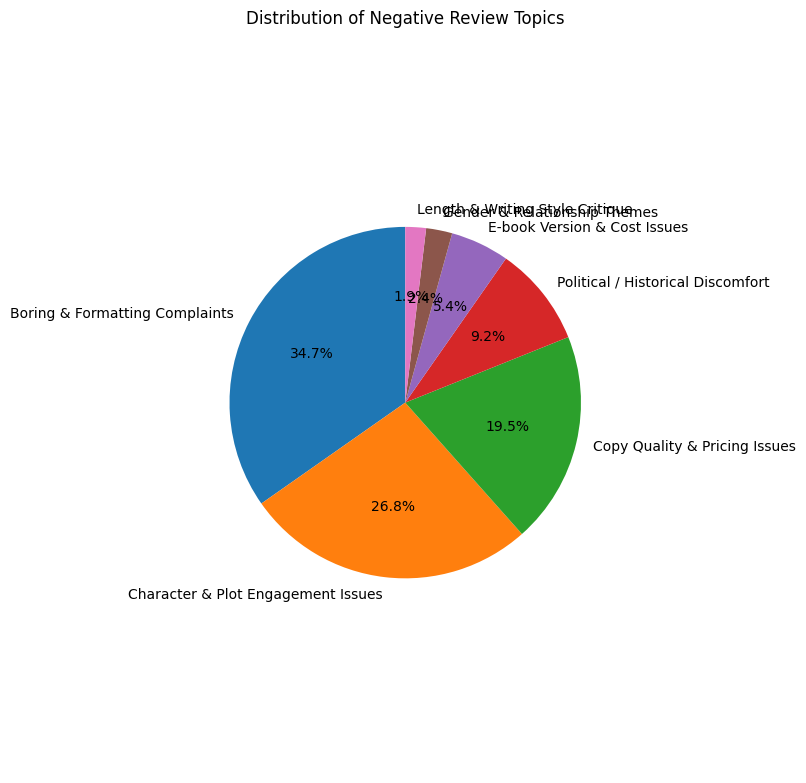

In [217]:

# 2. Map topic indices to human-readable labels
theme_labels = {
    0: "Copy Quality & Pricing Issues",
    1: "Political / Historical Discomfort",
    2: "Length & Writing Style Critique",
    3: "Character & Plot Engagement Issues",
    4: "Gender & Relationship Themes",
    5: "Boring & Formatting Complaints",
    6: "E-book Version & Cost Issues"
}
A['topic_label'] = A['topic'].map(theme_labels)

# 3. Compute the percentage of each topic within the negative set
topic_dist = (
    A['topic_label']
      .value_counts(normalize=True)  # fraction of negatives per topic
      .mul(100)                       # to percent
      .round(1)                       # one decimal place
)

# 4. Plot as a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    topic_dist.values,
    labels=topic_dist.index,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_title('Distribution of Negative Review Topics')
ax.axis('equal')  # ensure it's a circle
plt.tight_layout()
plt.show()

In [218]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

Reviews for Copy Quality & Pricing Issues

In [219]:
import textwrap

def wrap_text(s, width=80):
    return "\n".join(textwrap.wrap(str(s), width=width))

A_copy = A.copy()
# Apply to your long-text column, e.g. 'review'
A_copy['wrapped_review'] = A_copy['review'].apply(lambda x: wrap_text(x, width=20))

# Then display that column #.str.replace('\n', ' ')
A_copy[A_copy['topic_label']=="Copy Quality & Pricing Issues"][['wrapped_review','rating']].sample(1)
#A_copy[A_copy['topic_label']=="Copy Quality & Pricing Issues"]['wrapped_review'].str.replace('\n', ' ')[559]

,wrapped_review,rating
2552,Like most ever other\nreviewer here I read\nthe entire Enders\nseries up through\nthis book While\nEnders Game and\nSpeaker for the Dead\nare outstanding\nbooks five star\nworthy Xenocide and\nChildren of the Mind\nare simply\nirritating I\ndespised all the\ncharacters who were\nso selfcentered and\nso completely flawed\nyou have no\nconnection to them\nto care whether they\ndie or live and cant\nconceive they could\nsucceed at anything\nPage after page of\ncharacters\ncontemplating their\nrelationships with\nthe other characters\nmakes for a very\nboring read and I\nfound myself\nskimming much of the\nbook spoiler Without\nEnder who\nessentially\nwithdrawls from the\nnarrative to have a\nrelationship with\nhis angryattheworld\nwife there are\nsimply no\nsympathetic or\ninteresting\ncharacters that you\nreally care about\nBut hey at least I\nread all four books,2.0


Review for Length & Writing Style Critique

In [220]:
from IPython.display import HTML, display

# if you want to widen the entire table, you can also do
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# 2. Render the DataFrame as HTML with word-wrap enabled
html = ( A.loc[A['topic_label']=="E-book Version & Cost Issues"]
           .sample(1)
           .to_html()
           .replace('<table ',
                    '<table style="white-space: pre-wrap; word-wrap: break-word;" ')
        )
display(HTML(html))

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews,topic,0,1,2,3,4,5,6,topic_label
437,66873,1556909330,Dune,NaN,A1PD57C6XD75MV,1.0,Like many others I picked up DUNE based on its broadly accepted status as a SF classic I dont read much SF so I try to get to the Big Books War of the Worlds Enders Game Fahrenheit The Years Best anthologies etc This was not a good book The dialogue is stilted the characters are caricatures and everyones always hissing glaring or swallowing with a dry throat The plot is interesting enough but not nearly as complex or Byzantine as I had expected warring factions religious fervor doublecrossing nefarious rulers ulterior motives standard stuff really If anything the plot seems complicated because were told so little about what the Guild the Great Houses and CHOAM really are Anyway as a nonSF connoisseur I realize that I dont get to vote on which books are the classics But from where I stand DUNE is a poorlywritten lackluster repetitive tale Its not the best SF Ive ever read its not even the best book Ive read this month,2001-06-29,0,like pick DUNE base broadly accept status SF classic not sf try Big Books War Worlds Enders Game Fahrenheit Years Best anthology etc good dialogue stilte caricature everyone hiss glare swallow dry throat plot interesting nearly complex Byzantine expect war faction religious fervor doublecrosse nefarious ruler ulterior motive standard stuff plot complicated tell little Guild Great Houses CHOAM nonSF connoisseur realize not vote classic stand DUNE poorlywritten lackluster repetitive tale good SF ve good ve month,6,0.034391,0.126231,0.04464,0.109255,0.0,0.245626,0.430138,E-book Version & Cost Issues


In [221]:
from IPython.display import HTML, display

# if you want to widen the entire table, you can also do
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# 2. Render the DataFrame as HTML with word-wrap enabled
html = ( A.loc[A['topic_label']=="Length & Writing Style Critique"]
           .sample(1)
           .to_html()
           .replace('<table ',
                    '<table style="white-space: pre-wrap; word-wrap: break-word;" ')
        )
display(HTML(html))

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews,topic,0,1,2,3,4,5,6,topic_label
2513,162483,B0006ITZ4S,Children of the Mind,NaN,A1013EG9LC0SAZ,1.0,I never thought I would say this about a book in this series but I hate this book I was absolutely disappointed with the way Card chose to resolve his story Ill give him license since he may do what he will with his story but I feel so bitter about this ending to such a magnificent saga that I cant recommend this to anybody that isnt dying of curiousity at the end of XenocideAnd to those who believe you fit in this category Im sorry for the feelings you will like possess upon completion I honestly feel the same unrest now as I did when I finished Xenocide I hope everyday that Card will come to his senses and revise his plot here to be more logical less rushed more conclusive which some may argue with and more fulfilling to a character of such quality as Ender Wiggin,2004-11-15,0,series hate absolutely disappointed way Card choose resolve Ill license feel bitter end magnificent saga not recommend anybody not die curiousity end XenocideAnd believe fit category m sorry feeling like possess completion honestly feel unrest finish Xenocide hope everyday card come sense revise plot logical rush conclusive argue fulfil quality Ender Wiggin,2,0.075795,0.098432,0.331641,0.079924,0.011948,0.149597,0.252663,Length & Writing Style Critique


### Topic Modeling for positive reviews

In [222]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# package to print
from pprint import pprint

#### Tokenize processed reviews

In [223]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [224]:


from nltk.tokenize import word_tokenize

pos_token =  ratings_filtered.loc[ratings_filtered.sentiment == 1, "processed_reviews"].apply(word_tokenize)
#neg_tokens = ratings_filtered.loc[ratings_filtered.rating <= 2, "processed_reviews"].apply(word_tokenize)


#### Prepare dictionary and corpus for topic modeling

In [225]:


# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus
# Create the Dictionary and Corpus needed for Topic Modelling

#  Dictionary
id2word = corpora.Dictionary(pos_token)

#  Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in pos_token]



#### Fit LDA model

In [226]:
%%time
n = 7 # decided to start with 4 topics. There are advanced approaches like Kullback Leibler Divergence
                                                              # to obtain the optimal number of topics.

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Look at the topics and key words
pprint(lda_model.print_topics())





[(0,
  '0.030*"war" + 0.017*"reader" + 0.014*"take" + 0.013*"make" + 0.013*"work" + '
  '0.011*"enjoy" + 0.010*"real" + 0.010*"recommend" + 0.010*"write" + '
  '0.008*"French"'),
 (1,
  '0.044*"grow" + 0.037*"highly" + 0.029*"title" + 0.026*"meet" + '
  '0.023*"publish" + 0.020*"exercise" + 0.015*"emotion" + 0.015*"personality" '
  '+ 0.015*"ultimately" + 0.013*"entertaining"'),
 (2,
  '0.023*"french" + 0.023*"young" + 0.020*"woman" + 0.018*"precious" + '
  '0.017*"life" + 0.016*"movie" + 0.016*"mother" + 0.014*"man" + '
  '0.011*"vietnamese" + 0.010*"father"'),
 (3,
  '0.038*"situation" + 0.027*"beautiful" + 0.023*"series" + 0.022*"Hornblower" '
  '+ 0.018*"meet" + 0.017*"Grey" + 0.017*"ve" + 0.016*"prose" + 0.015*"fun" + '
  '0.015*"marry"'),
 (4,
  '0.023*"not" + 0.018*"love" + 0.017*"good" + 0.016*"like" + 0.012*"life" + '
  '0.012*"great" + 0.012*"find" + 0.012*"s" + 0.012*"know" + 0.011*"way"'),
 (5,
  '0.042*"Fowler" + 0.041*"Pyle" + 0.031*"Vietnam" + 0.027*"Greene" + '
  '0.026

Calculate the topic distribution

In [227]:
def topics_per_review(model, corpus):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs, _, _ = model[corp]
        dominant_topic = max(topic_percs, key=lambda x: x[1])[0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_review(model=lda_model, corpus=corpus)

In [228]:
topic_percentages_df = pd.DataFrame([
    {topic: prob for topic, prob in doc} for doc in topic_percentages
]).fillna(0)

dominant_topics_df = pd.DataFrame(dominant_topics,
                                  columns=["index", "topic"]).set_index("index")

topics_df = pd.merge(dominant_topics_df, topic_percentages_df,
                     left_index=True, right_index=True, how="left")

# Ensure column order is correct
topic_df = topics_df.loc[:, ["topic"] + list(range(n))]

# Display the resulting DataFrame
display(topic_df)

,topic,0,1,2,3,4,5,6
index,,,,,,,,
0,4,0.267174,0.000000,0.170767,0.000000,0.547921,0.000000,0.000000
1,4,0.131991,0.055997,0.135068,0.023343,0.529521,0.091416,0.032664
2,4,0.173116,0.011795,0.185709,0.032501,0.490862,0.094446,0.011571
3,2,0.148535,0.081796,0.319531,0.049063,0.238229,0.057441,0.105405
4,0,0.748550,0.000000,0.033972,0.000000,0.204949,0.000000,0.000000
...,...,...,...,...,...,...,...,...
23703,5,0.156152,0.023465,0.042342,0.020977,0.282118,0.303776,0.171171
23704,5,0.170696,0.026568,0.047453,0.023738,0.276888,0.380098,0.074559
23705,4,0.163692,0.038972,0.030653,0.000000,0.340814,0.291703,0.125355


In [229]:
topic_df.topic.value_counts()

,count
topic,
4,18828
0,2989
5,1010
2,343
6,218
3,165
1,155


Merge rating with topics

In [230]:
A = pd.merge(ratings_filtered[ratings_filtered['sentiment']==1], topic_df, left_index=True, right_index=True, how="inner")

A.sample(10)

,Unnamed: 0,book_id,book_title,book_price,user_id,rating,review,review_date,sentiment,processed_reviews,topic,0,1,2,3,4,5,6
15553,1363894,B000I7Z0ZU,It Can't Happen Here,NaN,A2X6RCSBEFDFYT,5.0,This book should be read by every American particularly in this time of crises in the United States This novel keeps the readers interest throughout and gives himher a lot to contemplate Its easy fast reading and shows the way a totalitarian state can emerge from the apathy of the American public,2012-07-07,1,American particularly crisis United States keep reader interest give himher lot contemplate easy fast reading show way totalitarian state emerge apathy american public,4,0.293091,0.000000,0.000000,0.065258,0.552274,0.000000,0.065078
16366,1526317,B000PRAU1W,Saving Grace,NaN,ASKSH6CLNWRV9,5.0,Saving Grace is one of the best Garwoods on the historical side Not only does it delve into the treatment of women at the time and theres some horrific allusions to wifebeating in this book but it also goes again into the politics that weigh heavily in the characters lives and the decisions that they make Garwood keeps up a quick pace and gives her characters just enough character flaws to keep them real If you read her novels involving the Clans youll notice that while each strapping Highlander is described in most of the other books she makes us see that the women who become involved with them see them as we tend to see people we love Its very refreshing My husband loves it when I read this stuff it puts me in a great frame of mind Enjoy,2005-05-17,1,Saving Grace good garwood historical delve treatment woman s horrific allusion wifebeate go politic weigh heavily live decision Garwood keep quick pace give flaw real involve Clans ll notice strap Highlander describe make woman involved tend people love refreshing husband love stuff put great frame mind enjoy,4,0.267119,0.020695,0.177657,0.011859,0.376599,0.092385,0.053686
21012,2187987,B00086CG5I,The Painted Veil,NaN,A2Z9L0JK0XRS61,3.0,The novel is eloquent especially in its description of the feelings of Kitty Walters wife Her need for affection and recognition is palpable but Walter is so highlystrung even for a Brit that he can hardly hold a conversation The plague in the remote region of China which Walter and later Kitty try to alleviate makes Kitty grow This part is deep and moving But Walter does not change at all he is the same intolerable reticent unforgiving husband He dies without forgiving Kitty And thats where Ed Norton made a smart revision His Walter does change and does forgive Kitty and the process is real and unsentimental The second mistake of Maugham is that when Kitty returns Beijin she returns to the arms of her lustful trashy lover That right there destroys the immense growth that had taken place in her soul upon seeing the suffering of the plagues victims Now at the end of the novel she hates herself And rightly so Ed Norton deserves a lot of credit for revising Maughams disappointing and confusing ending,2007-09-24,1,eloquent especially description feeling Kitty Walters wife need affection recognition palpable Walter highlystrung Brit hardly hold conversation plague remote region China Walter later Kitty try alleviate make Kitty grow deep move Walter change intolerable reticent unforgive husband die forgive Kitty s Ed Norton smart revision Walter change forgive Kitty process real unsentimental second mistake Maugham Kitty return Beijin return arm lustful trashy lover right destroy immense growth take place soul see suffering plague victim end hate rightly Ed Norton deserve lot credit revise Maughams disappointing confusing end,0,0.393214,0.000000,0.000000,0.275720,0.301807,0.000000,0.000000
5686,573275,0582528259,Jane Eyre (Simple English),NaN,ANCTF2MUL0LSC,3.0,I really liked this book though it took AGES for me to finish itOne of the reasons is that it is every wordy and sometimes I wasnt sure what they where talking about If your not very good with words then stay away 

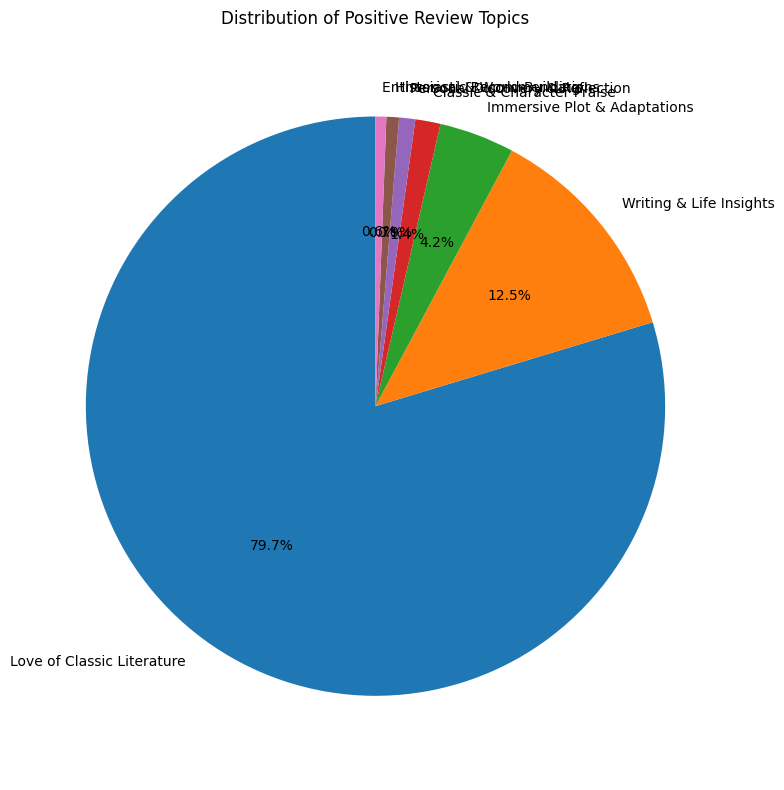

In [231]:
theme_labels_pos = {
   0: "Writing & Life Insights",
    1: "Enthusiastic Recommendations",
    2: "Classic & Character Praise",
    3: "Historical & World-Building",
    4: "Love of Classic Literature",
    5: "Immersive Plot & Adaptations",
    6: "Personal Discovery & Reflection"
}


A['topic_label'] = A['topic'].map(theme_labels_pos)

# 3. Compute the percentage of each topic within the negative set
topic_dist = (
    A['topic_label']
      .value_counts(normalize=True)  # fraction of negatives per topic
      .mul(100)                       # to percent
      .round(1)                       # one decimal place
)

# 4. Plot as a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    topic_dist.values,
    labels=topic_dist.index,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_title('Distribution of Positive Review Topics')
ax.axis('equal')  # ensure it's a circle
plt.tight_layout()
plt.show()

In [232]:
import textwrap

def wrap_text(s, width=80):
    return "\n".join(textwrap.wrap(str(s), width=width))

A_copy = A.copy()
# Apply to your long-text column, e.g. 'review'
A_copy['wrapped_review'] = A_copy['review'].apply(lambda x: wrap_text(x, width=20))

# Then display that column #.str.replace('\n', ' ')
A_copy[A_copy['topic_label']=="Personal Discovery & Reflection"][['wrapped_review','rating']].sample(5)
#A_copy[A_copy['topic_label']=="Personal Discovery & Reflection"]['wrapped_review'].str.replace('\n', ' ')[1142]

,wrapped_review,rating
21465,this is first book I\npurchased for my new\nKindlea Christmas\ngiftand I am\nenjoying boththe\nKindle is a great\nway to read maybe\neasier on the eyes\nthan real paper and\nMoby Dick a great\nnovel to begin my\nadventureIshmael\npaints a good\npicture of life\naround him and is\nsigning up for his\nfirst whaling\nvoyagegreat book,5.0
21078,At last I have\nfinished my journey\nwith the Pequod I\nactually enjoyed\nthis book whereas\nother people in my\nclass did not or did\nnot read at all I\nliked this book,4.0
21460,Whenever I find\nmyself growing grim\nabout the mouth\nwhenever it is a\ndamp drizzly\nNovember in my soul\nI read Moby Dick and\nif you havent yet\nwell I say give it a\ntry,5.0
18495,The item its all\nthat is mentioned\nbut the box was a\nlittle damaged I\nlove everything that\nMoore writes and\nthis is not an\nexception,4.0
14378,I bought the audio\ncd back in Novemeber\nof I have listened\nto this book at\nleast times if not\nmore When I say life\nchanging I mean it\nquite literally This\nbook made such an\nimpact on me and my\nlife in a very\npositive and\neffectual way So\nmuch so I have given\nthis bookcd as a\ngift over and over\nagain to my adult\nchildren my close\nfriends and extended\nfamily Everything\nWallace Wattles\nstates in the book\nis very thought\nprovoking and needs\nto be read and\nreread in order to\nimplement\neffectively into\nyour daily life I\nwill say not\neveryone comes away\nwith the insights\nthat I have so a\nperhaps basic belief\nin the metaphysical\nmay be a requirement\nThere is a level of\nspirituality in the\nbook however so the\nscience of getting\nhis is somewhat of a\nmisnomer What I do\nspecifically liked\nwas that he states\nin the very\nbeginning of the\nbook that this is\nnot a book about\nbeing spiritually or\nemotionally enriched\nbut very\nspecifically a how\nto book on getting\nrich I cannot say I\nam rich but having\nread this book and\npracticed Wattles\nmethods I can\nhonestly say I am\nfinancially as well\nas spiritually a lot\nbetter off than\nbefore I read this\nbook,5.0


### Bigram & Trigram Analysis

In [233]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Suppose `docs` is a list/Series of your preprocessed review strings:
docs = ratings_filtered.loc[ratings_filtered['rating']<=2,'processed_reviews'].tolist()

# 1a) Bigram frequencies
bigram_vect = CountVectorizer(
    ngram_range=(2,2),
    stop_words='english',
    min_df=2     # only keep bigrams that appear in ≥5 docs
)
X_bi = bigram_vect.fit_transform(docs)
bi_counts = X_bi.sum(axis=0).A1
bi_terms  = bigram_vect.get_feature_names_out()
df_bi = pd.DataFrame({'bigram': bi_terms, 'count': bi_counts})
top_bigrams = df_bi.sort_values('count', ascending=False).head(20)
print(top_bigrams)

# 1b) Trigram frequencies
trigram_vect = CountVectorizer(
    ngram_range=(3,3),
    stop_words='english',
    min_df=2
)
X_tri = trigram_vect.fit_transform(docs)
tri_counts = X_tri.sum(axis=0).A1
tri_terms  = trigram_vect.get_feature_names_out()
df_tri = pd.DataFrame({'trigram': tri_terms, 'count': tri_counts})
top_trigrams = df_tri.sort_values('count', ascending=False).head(20)
print(top_trigrams)


                bigram  count
14372      high school    163
13301     great gatsby    149
21074        moby dick    137
11161        feel like    121
30568     stephen king    113
36654         year ago     95
36714         year old     75
19073        look like     74
16969   kindle edition     68
28426  science fiction     62
257           act like     61
32061       th century     56
31152         sun rise     49
30566   stephanie plum     46
10746        fall love     46
36568    writing style     45
17000   kindle version     45
23787      people like     45
36402     write review     44
24712     poorly write     44
                     trigram  count
30518       stephen king fan     17
7137   death come archbishop     16
18229       like little girl     16
30515  stephanie plum series     15
13191   great american novel     14
30182      spoil rich people     14
14363    high school student     13
36093        work truly good     12
35506         woman act like     12
20543     

In [234]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assume `docs` is a list of your preprocessed review strings:
docs = ratings_filtered.loc[ratings_filtered['rating']<=1,'processed_reviews'].tolist()

def top_ngrams_tfidf(docs, ngram_range=(2,2), top_n=20, min_df=2):
    vect = TfidfVectorizer(
        ngram_range=ngram_range,
        stop_words='english',
        min_df=min_df
    )
    X = vect.fit_transform(docs)
    # Compute mean tfidf score for each n-gram
    avg_tfidf = np.asarray(X.mean(axis=0)).ravel()
    feats = vect.get_feature_names_out()
    df = pd.DataFrame({
        'ngram': feats,
        'tfidf': avg_tfidf
    })
    return df.sort_values('tfidf', ascending=False).head(top_n)

# Top 20 bigrams
top_bigrams = top_ngrams_tfidf(docs, ngram_range=(2,2), top_n=20)
print("Top 20 bigrams by TF-IDF:")
print(top_bigrams)

# Top 20 trigrams
top_trigrams = top_ngrams_tfidf(docs, ngram_range=(3,3), top_n=20)
print("\nTop 20 trigrams by TF-IDF:")
print(top_trigrams)

# If you want both 2- and 3-grams together:
top_2_3grams = top_ngrams_tfidf(docs, ngram_range=(2,3), top_n=20)
print("\nTop 20 2-3-grams by TF-IDF:")
print(top_2_3grams)

Top 20 bigrams by TF-IDF:
                 ngram     tfidf
15402     stephen king  0.006963
7279       high school  0.006745
17488      waste money  0.005168
15400   stephanie plum  0.004948
5703         feel like  0.004946
18550         year old  0.004906
12422     poorly write  0.004413
8603    kindle edition  0.004394
8628    kindle version  0.004103
9635         look like  0.003964
18521         year ago  0.003778
18481    writing style  0.003640
10656        moby dick  0.003499
12313      plum series  0.003197
8393   janet evanovich  0.003060
13949      rich people  0.002925
14344  science fiction  0.002876
14209       save money  0.002787
8392         jane eyre  0.002678
15678         sun rise  0.002608

Top 20 trigrams by TF-IDF:
                                 ngram     tfidf
15281            stephanie plum series  0.004111
11293                      old man sea  0.002797
7226               high school student  0.002524
15283                 stephen king fan  0.002445
15121   

### Supervised Learning for sentiment analysis

#### Random Forest Classifier

In [235]:
def show_summary_report(actual, prediction, probabilities):

    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, prediction)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.savefig("rfc_performance_report.png", dpi=100)
    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.48      0.65       580
           1       0.94      1.00      0.97      4742

    accuracy                           0.94      5322
   macro avg       0.96      0.74      0.81      5322
weighted avg       0.94      0.94      0.93      5322

Accuracy : 0.9425 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9406 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9985 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7415                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


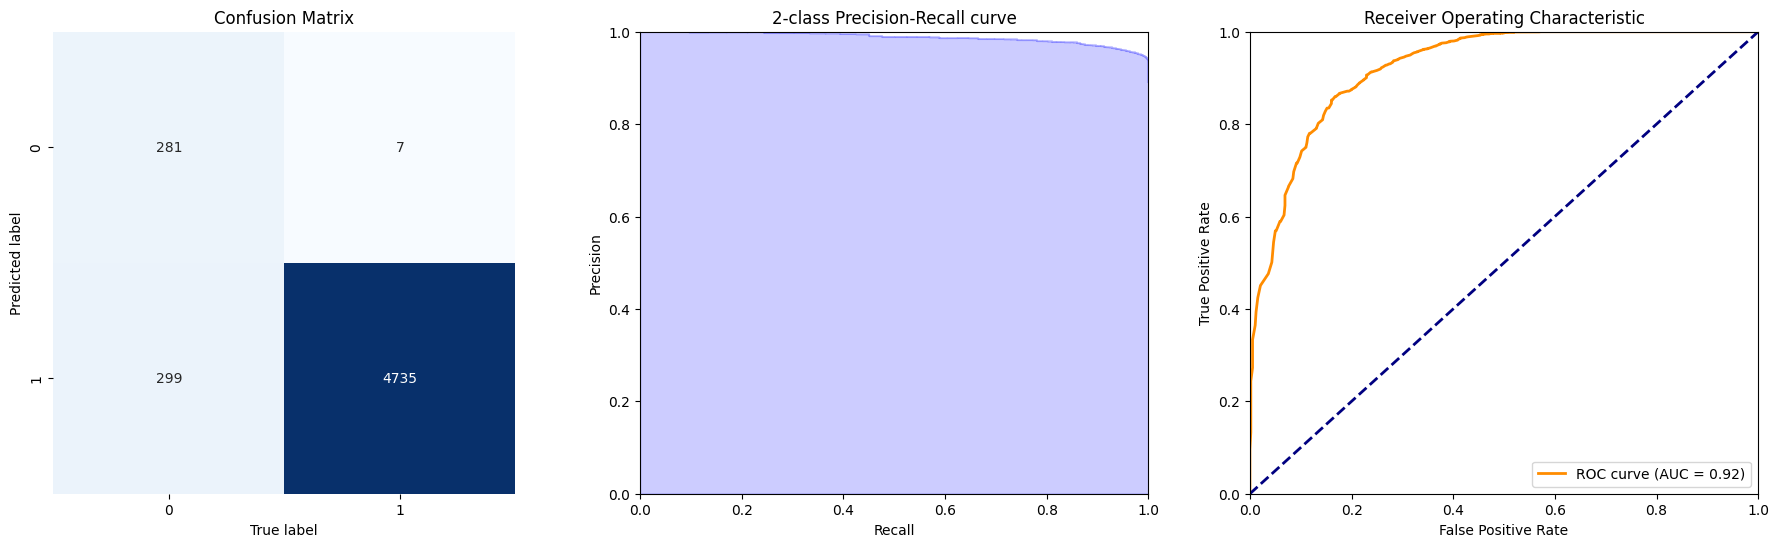

In [236]:
# Initialize the model
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)

# Train the classifier with the training data
rf_clf.fit(X_train_svd, y_train)

# Make predictions on the test data
predictions = rf_clf.predict(X_test_svd)

# Store probabilities of predictions being 1
probabilities = rf_clf.predict_proba(X_test_svd)[:,1]

print("Classification Report:\n", classification_report(y_test, predictions))

accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)




#### XGBoost Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.55      0.67       580
           1       0.95      0.99      0.97      4742

    accuracy                           0.94      5322
   macro avg       0.91      0.77      0.82      5322
weighted avg       0.94      0.94      0.94      5322

Accuracy : 0.9416 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9473 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9895 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7697                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


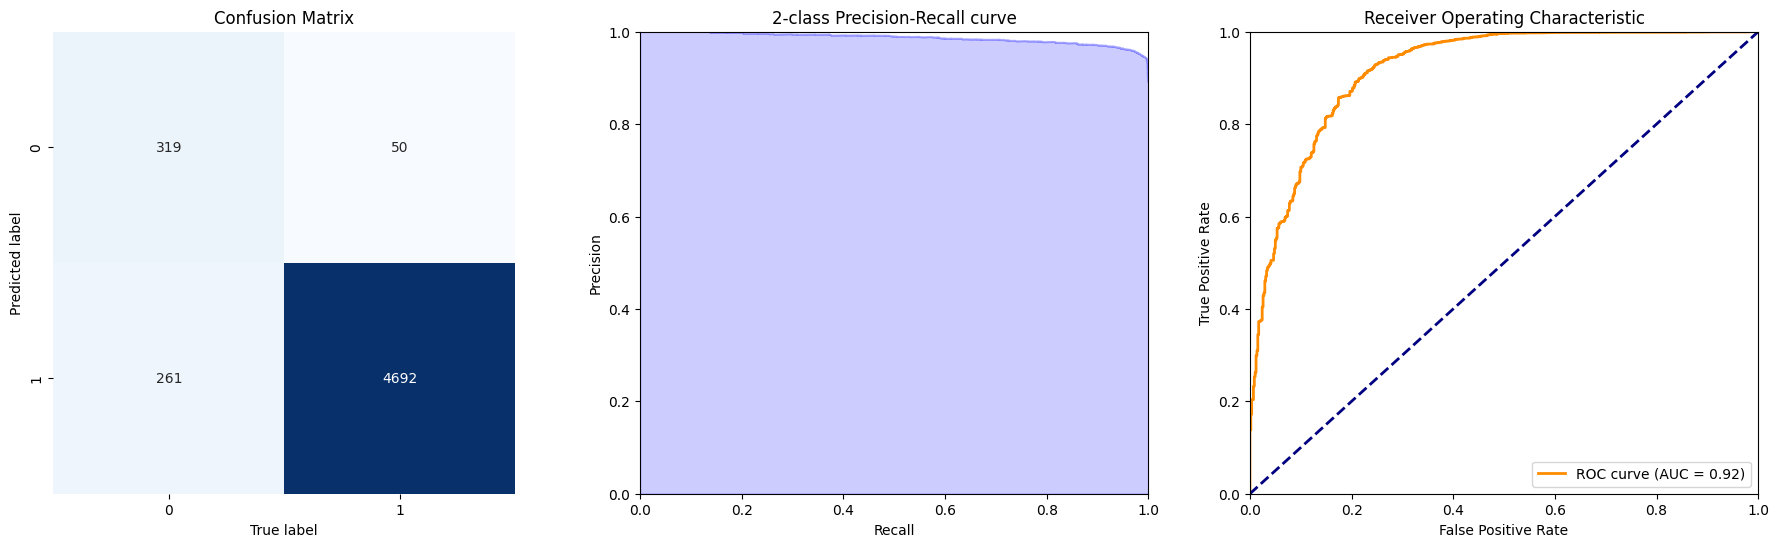

In [237]:
import xgboost as xgb
#Creating an XGBoost classifier
xgb_clf = xgb.XGBClassifier()

#Training the model on the training data
xgb_clf.fit(X_train_svd, y_train)

#Making predictions on the test set
predictions = xgb_clf.predict(X_test_svd)

# Store probabilities of predictions being 1
probabilities = xgb_clf.predict_proba(X_test_svd)[:,1]

print("Classification Report:\n", classification_report(y_test, predictions))

accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)


####LogisticRegression

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.75      0.41       580
           1       0.96      0.76      0.85      4742

    accuracy                           0.76      5322
   macro avg       0.62      0.76      0.63      5322
weighted avg       0.89      0.76      0.80      5322

Accuracy : 0.7623 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9620 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7634 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7584                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


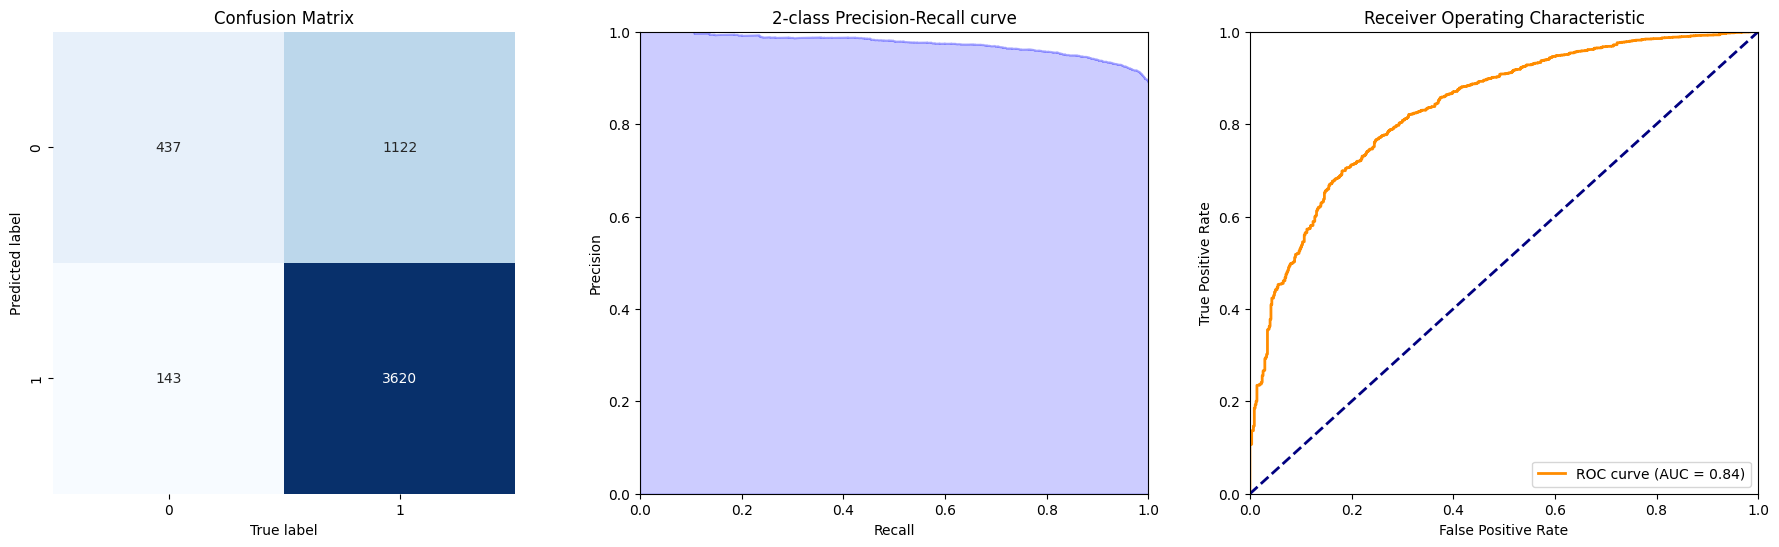

In [238]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(solver = 'saga',
                         class_weight='balanced',max_iter=1000,
                         C = 10, penalty='l2' )

#Training Model
lgr.fit(X_train_svd, y_train)

#Making predictions on the test set
predictions = lgr.predict(X_test_svd)

# Store probabilities of predictions being 1
probabilities = lgr.predict_proba(X_test_svd)[:,1]

print("Classification Report:\n", classification_report(y_test, predictions))

accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)

####Stacking Classifier

In [241]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# 2) Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42)),
    ('xgb', xgb.XGBClassifier(subsample= 0.9,
                              reg_lambda = 0.5, reg_alpha = 0, n_estimators= 800,
                              min_child_weight = 1, max_depth = 5, learning_rate = 0.046415888336127774,
                              gamma = 0.1, colsample_bytree = 1.0)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# 3) Define meta learner
meta_learner = LogisticRegression(solver = 'saga',
                         class_weight={0:3, 1:1},max_iter=1000,
                         C = 10, penalty='l2')


# 4) Create stacking classifier
stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,                   # number of folds for out-of-fold preds
    passthrough=False,      # if True, also include original features to meta learner
    n_jobs=-1
)



In [242]:
# 5) Train & evaluate
stack.fit(X_train_svd, y_train)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0.1,
                                              grow_poli...
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(C=10,
                                                      class_weight={0: 3, 1: 1},
                                                      max_iter=1000,
                                                      solver='saga'),
                   n_jobs=-1)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71       580
           1       0.96      0.97      0.97      4742

    accuracy                           0.94      5322
   macro avg       0.86      0.83      0.84      5322
weighted avg       0.94      0.94      0.94      5322

Accuracy : 0.9404 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9614 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9722 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8266                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


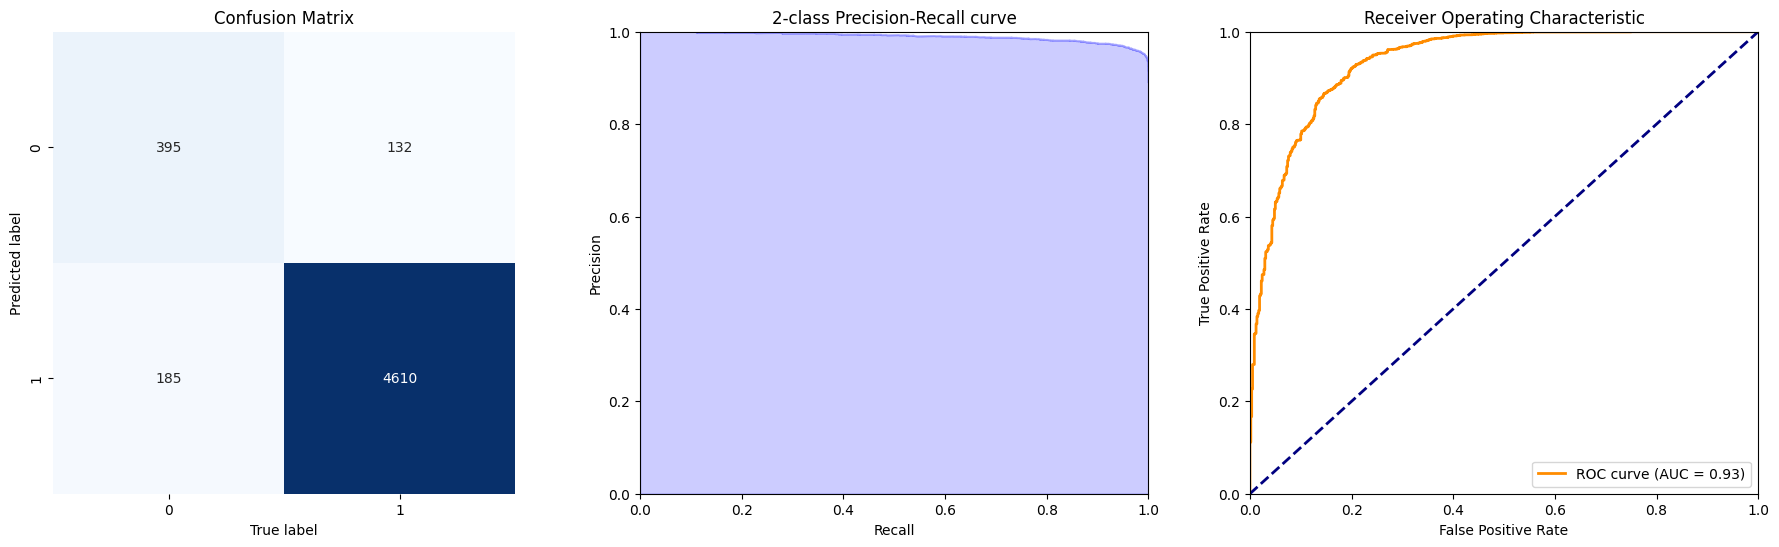

In [243]:
y_pred = stack.predict(X_test_svd)

y_pred_proba = stack.predict_proba(X_test_svd)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))

accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, y_pred, y_pred_proba)